# Exploring Events Data from Burning Man Festival

![](images/TitlePage.jpg)

Burning Man is a week-long annual arts and entertainment festival in Northwest Nevada, started in 1989, that attracts almost 70,000 attendees from all over the world. Burning Man has a decentralized non-profit structure. Attendees (aka Burners) self-organize into groups (called camps) that host numerous events. Since 2009, a portion of these events have been publicized ahead of time in an online schedule. This notebook is an exploration of that dataset.

<a href='#intro'> What does the raw data look like? </a>
- <a href='#inspect'> What does the scraped dataset look like? </a>
- <a href='#missing'> Let's check for missing values </a>
    
<a href='#eventtypedist'> What kinds of events exist? </a>
- <a href='#eventsoveryears'> How has the number of events varied over the years? </a>
- <a href='#eventdaydist'> How does the number of events vary throughout the week? </a>
- <a href='#eventtimetypedist'> How does the number of events vary throughout the day? </a>

<a href='#repeatevents'> What proportion events occur several times throughout the week? </a>

<a href='#eventlength'> How long is a typical event? </a>

<a href='#uniquecamps'> Exploring camp statistics </a>
- <a href='#repeatedcampnames'> Do the same camps appear multiple times in the schedule, with minor variations?</a>
- <a href='#mostactivecamps'>  Who are the most active camps? </a>
- <a href='#camplifespan'> What is the lifespan of a typical camp? </a>

<a href='#eventdescriptions'> Exploring event descriptions </a>
- <a href='#visualizeeventtitles'> Visualization of Event names </a>
- <a href='#visualizecampnames'> Visualize of Camp Names </a>
- <a href='#sentiment'> Sentiment Analysis of Event Descriptions </a>

<a href='#locations'> How are event locations distributed? </a>

<a href='#others'> the Other Events </a>

In [5]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
import numpy as np;

import fuzzywuzzy
from fuzzywuzzy import process

from functools import reduce
from tqdm import tqdm
from pylab import *;

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from scipy.stats import ttest_ind, describe

import nltk, re, pprint
from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

from scipy import sparse

%matplotlib inline

<a id='intro'></a>
# Introduction

The dataset (which was scraped and cleaned in another notebook) consists of over 20,000 events dating back to 2009. Along with the event name, several variables including the event description, the hosting camp, location, type, and date are included.

Here's an example. The Bad Idea Bar. This event occurs almost every day at midnight at a camp called The Academy of Arts and Sciences. It's a "Gathering/Party" type event. And it's description pretty clearly says what's going to happen at the event. But, there's clearly a data quality issue with the event time. Midnight to 11:45 PM doesn't really make sense. We can assume that means it starts at around midnight and continues until whenever, but this can make the data analysis tricky. 

![](images/Example.jpg)

<a id='inspect'></a>

## Inspecting the Dataset

In [6]:
df = pd.read_csv('raw_data/cleaned_up.csv')

df.sample(5)

,Description,Title,Hosted by Camp,Location,Type,Contact Email,URL,Located at Art,Year,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2
15527,The bar designer and attractive cohorts want t...,Mid-Week Peak Party Night at Red Bar,Red Bar,NaN,Gathering/Party,NaN,NaN,NaN,2016,0,0,0,7 p.m. – midnight,0,0,0,0,0
1598,Dreams Visions Hallucinations Fantasies-these ...,Dreams Visions Hallucinations Fantasies,Two Lanterns Camp,NaN,Care/Support,bobo@cruzio.com,http://www.taintedpackets.com/,NaN,2010,0,9 a.m. – 5 p.m.,9 a.m. – 5 p.m.,9 a.m. – 5 p.m.,9 a.m. – 5 p.m.,9 a.m. – 5 p.m.,9 a.m. – 5 p.m.,0,0
5448,"During the past 2 years, Reverbia's Concerts i...",Concerts In the Shade Series,Reverbia: All Live Music Camp,NaN,Performance,reverbia.bman@gmail.com,http://www.facebook.com/Reverbia,NaN,2012,0,0,1 p.m. – 3:30 p.m.,1 p.m. – 3:30 p.m.,1 p.m. – 3:30 p.m.,1 p.m. – 3:30 p.m.,1 p.m. – 3:30 p.m.,0,0
16209,2Man guides you to clear dark forces that haun...,SHAMANIC BODYWORK to Destroy Your Demons,Shamandome Camp,6:45 and G Shamandome Camp,Class/Workshop,barnabyruhe@gmail.com,http://shamandome.org/,NaN,2016,0,0,0,0,0,11 a.m. – 1 p.m.,0,0,0
4673,We get mighty dirty over here at Whiskey & Dus...,Mistress Immaculate's Masochist Maid Brigade,Whiskey and Dust,whiskey and dust,Parade,weaselptljr@hotmail.com,http://www.whiskyanddust.com/events,NaN,2011,0,0,0,0,0,4 p.m. – 5 p.m.,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 18 columns):
Description       20165 non-null object
Title             20165 non-null object
Hosted by Camp    18258 non-null object
Location          7145 non-null object
Type              20165 non-null object
Contact Email     8749 non-null object
URL               8529 non-null object
Located at Art    444 non-null object
Year              20165 non-null int64
Sunday            20165 non-null object
Monday            20165 non-null object
Tuesday           20165 non-null object
Wednesday         20165 non-null object
Thursday          20165 non-null object
Friday            20165 non-null object
Saturday          20165 non-null object
Sunday2           20165 non-null object
Monday2           20165 non-null object
dtypes: int64(1), object(17)
memory usage: 2.8+ MB


<a id='missing'></a>
## Missing Values

Looks like very events have labels regarding whether they're near art pieces. 

Approximately 50% are also missing location data, which may make them hard to find! Location could possibly be inferred by the camp name and/or the event description however. 

Many events are also missing a URL or Contact Email, although this is probably not very important for Burning Man. 

Around 10% of events are missing camp information as well, which is quite important, but again, might be inferred from the description.

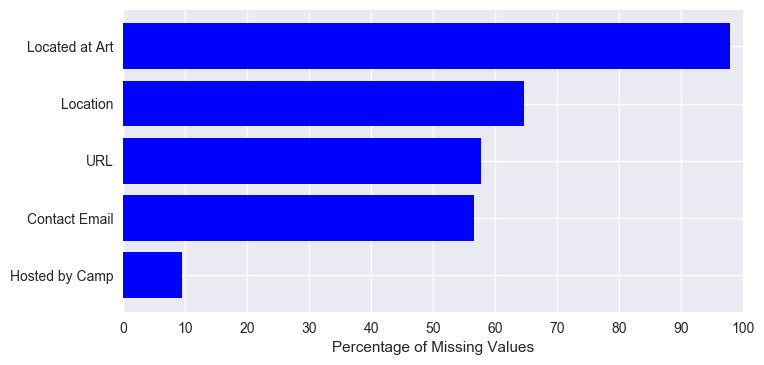

In [182]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9

fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(111)

rects = ax.barh(ind, 100*missing_df.missing_count.values/len(df), color='blue')
ax.set_xbound(0, 100)
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Percentage of Missing Values")
ax.xaxis.set_major_locator(MultipleLocator(10))

plt.show()

<a id='eventtypedist'></a>
# Event Type Distribution

More clearly visualizing the distribution of event types, we can see that gathering/party and class/workshop events are very popular, with relatively few kid-friendly and fire type events. Therefore classifying events into different types will suffer from data imbalance issues. In other words, we don't have equal distributions of all event types.

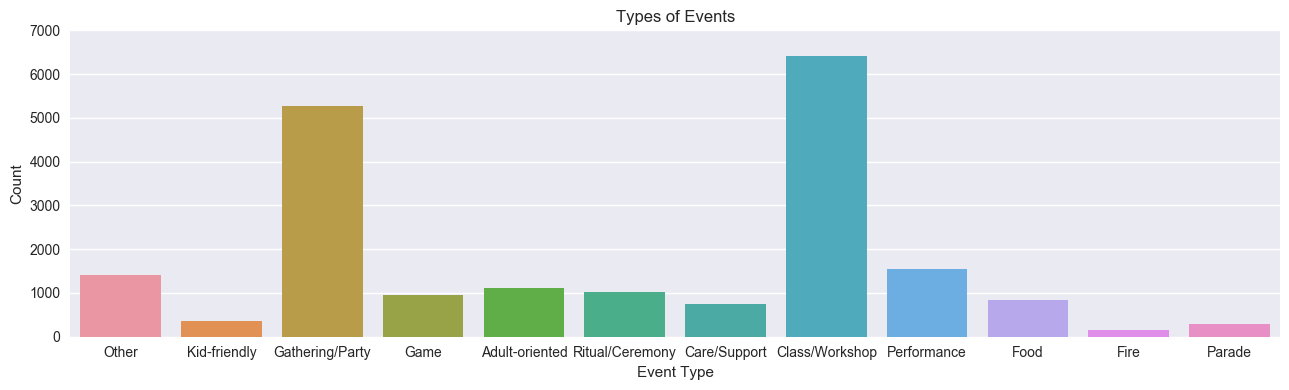

In [4]:
fig = plt.figure(figsize=(13, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.countplot(df.Type, ax=axes1)

axes1.set_ylim(0, 7000);
axes1.set_xlabel('Event Type');
axes1.set_ylabel('Count');
axes1.set_title('Types of Events');

fig.tight_layout()

<a id='eventsoveryears'></a>
## Number of Events over the Years

The total number of scheduled events has been steadily rising over the years, which can be  largely attributed to increased promotion and use of the event scheduling system. It's unclear whether the actual number of events has been increasing.

By type, much of this growth belongs to increased numbers of classes/workshops and parties. Other types of events have exhibited either slow or no growth. This means that going forward to future years, we can likely expect even larger fractions of worshop and party type events.

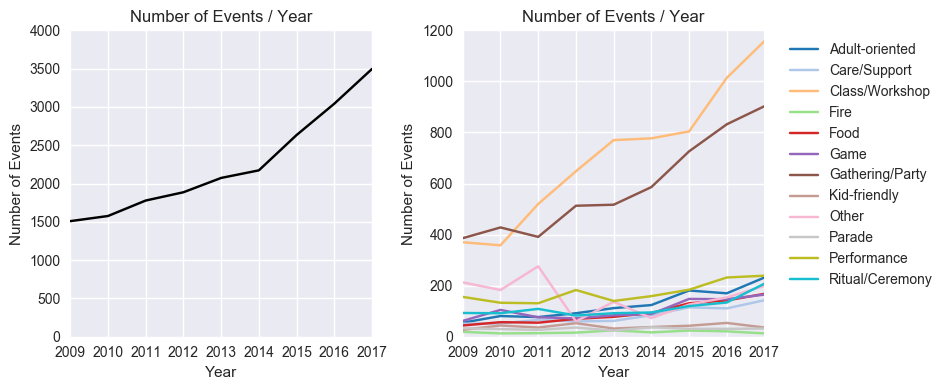

In [135]:
start = 0.0;
stop  = 1.0;
number_of_lines = len(grouped_by_type_year.index.levels[0]) + 1;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100)

axes1 = fig.add_subplot(121)

axes1.plot(df_year_counts.index, df_year_counts.values, color='black', ls='-')

#axes1.grid(False)
#axes1.set_facecolor('white')
axes1.set_xlim(2009, 2017)
axes1.set_ylim(0, 4000)

axes1.set_xlabel('Year')
axes1.set_ylabel('Number of Events')
axes1.set_title('Number of Events / Year')

axes1.xaxis.set_major_locator(MultipleLocator(1))

axes2 = fig.add_subplot(122)

for i, event_type in enumerate(grouped_by_type_year.index.levels[0]):
    axes2.plot(grouped_by_type_year[event_type].sort_index().index.values, 
               grouped_by_type_year[event_type].sort_index().values, 
               color=colors[i], ls='-')

axes2.legend(grouped_by_type_year.index.levels[0], loc='upper right', bbox_to_anchor=(1.6, 1.0))
    
#axes2.grid(False)
#axes2.set_facecolor('white')
axes2.set_xlim(2009, 2017)
axes2.set_ylim(0, 1200)

axes2.set_xlabel('Year')
axes2.set_ylabel('Number of Events')
axes2.set_title('Number of Events / Year')

axes2.xaxis.set_major_locator(MultipleLocator(1))

fig.tight_layout();

<a id='eventdaydist'></a>
## Events by Day

Let's take a look at the event distribution by day. The middle of the week (Wednesday) seems to be the busiest. Makes sense. Early in the week people are still arriving and setting things up. Later in the week people get into party mode, and then pack out. 

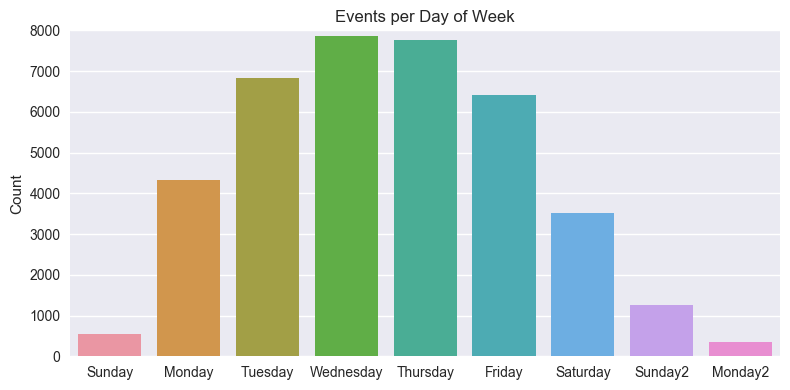

In [215]:
counts = (df[df.columns.values[-9:]] != '0').sum().reset_index().rename(columns={"index": "day", 0:"count"})

fig = plt.figure(figsize=(8, 4), dpi=100)

axes1 = fig.add_subplot(111)

sns.barplot(x='day', y='count', data=counts, ax=axes1)

axes1.set_ylim(0, 8000)
axes1.set_xlabel('')
axes1.set_ylabel('Count')
axes1.set_title('Events per Day of Week')

fig.tight_layout()

For the most part, the event distributions by type are the same. It does seem like performances are slightly skewed towards later in the week.

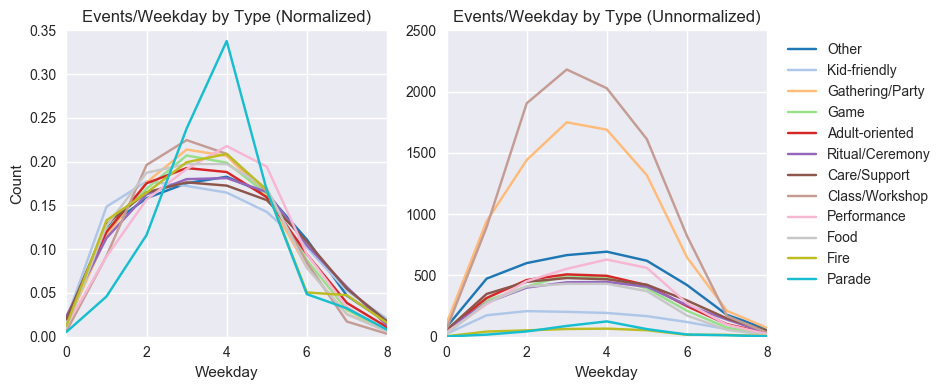

In [21]:
event_types = df['Type'].unique()

start = 0.0;
stop = 1.0;
number_of_lines = len(event_types) + 1;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100)

axes1 = fig.add_subplot(121)
axes2 = fig.add_subplot(122)

for i, event_type in enumerate(event_types):
    temp_df = (df[df['Type'] == event_type][df.columns.values[-9:]] != '0').sum().reset_index().rename(columns={"index": "day", 0:"count"})
    
    axes1.plot(temp_df.index, temp_df['count']/temp_df['count'].sum(), color=colors[i], ls='-');
    axes2.plot(temp_df.index, temp_df['count'], color=colors[i], ls='-');

axes2.legend(event_types, loc='upper right', bbox_to_anchor=(1.55, 1));
 
axes1.set_xlim(0, 8)
axes2.set_xlim(0, 8)
axes1.set_ylim(0, 0.35)
axes2.set_ylim(0, 2500)
axes1.set_xlabel('Weekday')
axes2.set_xlabel('Weekday')
axes1.set_ylabel('Count (Normalized)')
axes1.set_ylabel('Count')
axes1.set_title('Events/Weekday by Type (Normalized)')
axes2.set_title('Events/Weekday by Type (Unnormalized)')

fig.tight_layout()

All of the distributions have mean values between 3.43 and 3.76 (Wednesday) with variances between 1.38 and 1.92 days. They all skew slightly towards the beginning of the week, and tend to have shorter tails relative to a normal distribution (although it's not exactly a fair comparison since the x axis isn't continuous).

In [7]:
event_types = df['Type'].unique()
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2']

counts = {}

for event_type in event_types:
    df_temp = (df[df['Type'] == event_type][df.columns.values[-9:]] != '0')
    
    for i, day in enumerate(days_of_week):
        df_temp[day] = (i+1)*df_temp[day].astype(int)

    counts[event_type] = [x-1 for x in list(df_temp.values.flatten()) if x != 0]

In [9]:
df_temp = pd.DataFrame(columns=['Event Type', 'Mean', 'Median', 'Variance', 'Skewness', 'Kurtosis'])

for key in counts.keys():
    results = describe(counts[key])
    
    df_temp = df_temp.append({'Event Type': key, 'Mean': results.mean,
                              'Median': np.median(counts[key]), 'Variance': results.variance, 
                              'Skewness': results.skewness, 'Kurtosis': results.kurtosis}, 
                              ignore_index=True)
    
df_temp#.sort_values(by='Mean')

,Event Type,Mean,Median,Variance,Skewness,Kurtosis
0,Other,3.642876,4.0,3.433546,0.150858,-0.720473
1,Kid-friendly,3.534805,3.0,3.667862,0.291544,-0.744337
2,Gathering/Party,3.467123,3.0,2.734465,0.220287,-0.471452
3,Game,3.496073,3.0,2.861337,0.190082,-0.583532
4,Adult-oriented,3.522151,3.0,3.136725,0.198951,-0.620773
5,Ritual/Ceremony,3.659367,4.0,3.409277,0.136352,-0.720197
6,Care/Support,3.638071,4.0,3.549622,0.194878,-0.755357
7,Class/Workshop,3.481459,3.0,2.389787,0.185905,-0.585855
8,Performance,3.684302,4.0,2.736343,0.052145,-0.558620
9,Food,3.433074,3.0,2.752032,0.201565,-0.627102


We can use the T-test to measure the probability that these differences occured due to random chance. Since the populations have unequal variances and unequal sample sizes we use Welch's t-test rather than Student's t-test (although we still maintain the assumption of a Gaussian normal distribution, which isn't totally accurate here). And since the mean-values and variances are very similar, the contribution to the t-value will be dominated by the difference in sample sizes.

$$t\quad = \quad {\; \overline{x}_1 - \overline{x}_2 \; \over \sqrt{ \; {\sigma_1^2 \over n_1} \; + \; {\sigma_2^2 \over n_2} \quad }}$$

The T-test is fairly robust against non-normality (but not asymmetry) so we should be fine using it here. More info on this in John Cook's blog: https://www.johndcook.com/blog/2018/05/11/two-sample-t-test/

A large p-value is indicative of strong evidence for the null hypothesis, which is that event means are equal. We see here that child-friendly events, parties, games, and adult-oriented events all likely peak at approximately the same time of the week. Wheres compared to this group of event types, Other events, rituals/ceromonies, care/support, performances, and parades all are likely to have peak occurances at other points of the week. This could be indicative of a fundamental difference in the nature of these events. Child-friendly, parties, games, and adult events can all be thought of as "game-like". People may be most collectively willing to "play" at a certain time of the week, and participate in other types of events at other days.

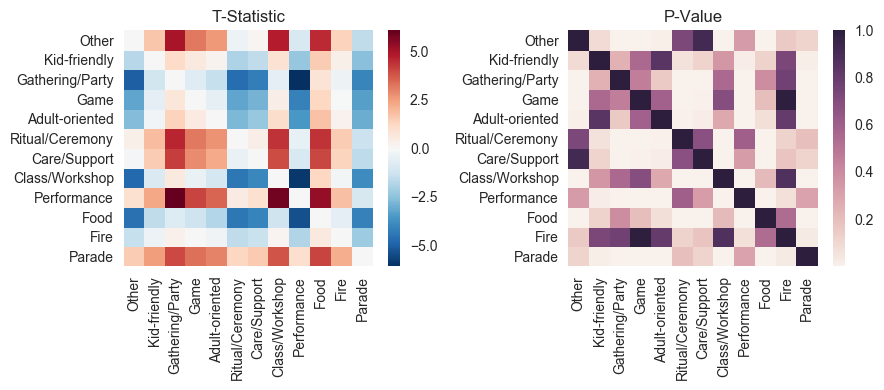

In [150]:
t = np.zeros((12, 12))
p = np.zeros((12, 12))

for i in range(len(event_types)):
    for j in range(len(event_types)):
        tt = ttest_ind(counts[event_types[i]], counts[event_types[j]], equal_var=False)
        
        t[i, j] = tt[0]
        p[i, j] = tt[1]
        
fig = plt.figure(figsize=(9, 4), dpi=100)

axes1 = fig.add_subplot(121)
axes2 = fig.add_subplot(122)

sns.heatmap(t, annot=False, ax=axes1, xticklabels=event_types, yticklabels=event_types)
sns.heatmap(p, annot=False, ax=axes2, xticklabels=event_types, yticklabels=event_types)

axes1.set_title('T-Statistic')
axes2.set_title('P-Value')

fig.tight_layout()

Let's next investigate the event distribution by hour. To do so we'll need to construct a function that parses the data and returns a distribution.

In [13]:
def convert_12_to_24(time):
    if 'a.m.' in time:
        time = time.replace(' a.m.', '')
        if ':' not in time:
            time = time + ':00'    
    elif 'p.m.' in time:
        time = time.replace(' p.m.', '')
        if ':' not in time:
            if '12' in time:
                time = time + ':00'
            else:
                time = str(int(time)+12) + ':00'
        elif '12' in time:
            pass
        else:
            time_split = time.split(':')
            time = str(int(time_split[0])+12) + ':' + time_split[1]
    elif 'midnight' in time:
        time = '23:45'
    elif 'noon' in time:
        time = '12:00'
            
    return time

def construct_cumulative_times(df):
    # df = dataframe consisting of a list of times
        
    times = [];
    
    for hour in np.arange(0, 24):
        for minutes in np.arange(0, 60, 15):
            time = str(hour) + ':' + str(minutes)
            time_date = datetime.datetime.strptime(time, '%H:%M').time()
            times.append(time_date)          
            #times.append(str(hour).zfill(2)+':'+str(minutes).zfill(2))
    
    df_cum = pd.DataFrame(data={'time':times, 'count':[0]*len(times)});

    for row in tqdm(df.values): 
        if row == '0':
            pass;
        elif row == 'All Day':
            df_cum['count'].values[:] = df_cum['count'].values[:] + 1;
        else:
            split = row.split(' – ');
            
            split[0] = convert_12_to_24(split[0])
            split[1] = convert_12_to_24(split[1])

            start_time = datetime.datetime.strptime(split[0], '%H:%M')
            end_time   = datetime.datetime.strptime(split[1], '%H:%M')
            
            start_time = (start_time - datetime.timedelta(minutes=start_time.minute % 15)).time()
            end_time   = (end_time   - datetime.timedelta(minutes=end_time.minute   % 15)).time()
            
            #if(end_time == datetime.datetime.strptime('23:59', '%H:%M').time()):
            #    end_time = datetime.datetime.strptime('23:45', '%H:%M').time();
            
            #print(row)
            
            index_first  = df_cum['time'][df_cum['time'] == start_time].index.tolist()[0];
            index_second = df_cum['time'][df_cum['time'] == end_time].index.tolist()[0];
        
            df_cum['count'].values[index_first:index_second] = df_cum['count'].values[index_first:index_second] + 1;
    
    return df_cum;

def get_time_diff(df):
    # df = dataframe consisting of a list of times
        
    times = [];

    for row in tqdm(df.values): 
        if row == '0':
            times.append(np.nan);
        elif row == 'All Day':
            times.append((datetime.datetime.strptime('23:59', '%H:%M')-datetime.datetime.strptime('00:00', '%H:%M')).total_seconds()/3600)
        else:
            split = row.split(' – ');
            
            split[0] = convert_12_to_24(split[0])
            split[1] = convert_12_to_24(split[1])

            times.append((datetime.datetime.strptime(split[1], '%H:%M')-datetime.datetime.strptime(split[0], '%H:%M')).total_seconds()/3600)
    
    return times;

Take a quick look at some of the times. It doess look like there are some erroneous values like events ending before start, which could imply that the event organizers only listed a start time.

In [14]:
times = [time for time in df['Sunday'].values if time != '0' and time != 'All Day']

times

['10 p.m. – 9:45 p.m.',
 '9 a.m. – 10 a.m.',
 'midnight – 11:45 p.m.',
 '1 a.m. – 2 a.m.',
 '6 a.m. – 11:45 p.m.',
 '6:30 a.m. – 7 a.m.',
 '7 a.m. – 9 a.m.',
 '7 p.m. – 9 p.m.',
 '8 a.m. – 11 a.m.',
 '8 a.m. – 9 a.m.',
 '9 a.m. – 9:30 a.m.',
 '9 a.m. – 7 p.m.',
 '9 a.m. – noon',
 '9 a.m. – 1 a.m.',
 '9 a.m. – 9 a.m.',
 '9 a.m. – 9 p.m.',
 '9 a.m. – 2 p.m.',
 '9 a.m. – 5 p.m.',
 '9 a.m. – 9:30 a.m.',
 '9 a.m. – 9 a.m.',
 '9:30 a.m. – 1 p.m.',
 '10 a.m. – 7 p.m.',
 '10 a.m. – 6 p.m.',
 '10 a.m. – 1 p.m.',
 '10 a.m. – 7 p.m.',
 '10 a.m. – 11 a.m.',
 '10 a.m. – 1 a.m.',
 '10 a.m. – 5 p.m.',
 '10 a.m. – 1 a.m.',
 '10 a.m. – 1 p.m.',
 '11 a.m. – 2 p.m.',
 '11 a.m. – noon',
 '11 a.m. – noon',
 '11 a.m. – 3 a.m.',
 '11:30 a.m. – 12:30 p.m.',
 'noon – 3 p.m.',
 'noon – 11 p.m.',
 'noon – 2 p.m.',
 'noon – 1:30 p.m.',
 'noon – 7 p.m.',
 'noon – 8 p.m.',
 '12:30 p.m. – 5 p.m.',
 '1 p.m. – 2 p.m.',
 '1 p.m. – 7 p.m.',
 '1 p.m. – 1:30 p.m.',
 '2 p.m. – 5 p.m.',
 '2 p.m. – 5 p.m.',
 '3 p.m. – 7 p.m.

Overall though, it looks like there's basically no difference in distribution between different days.

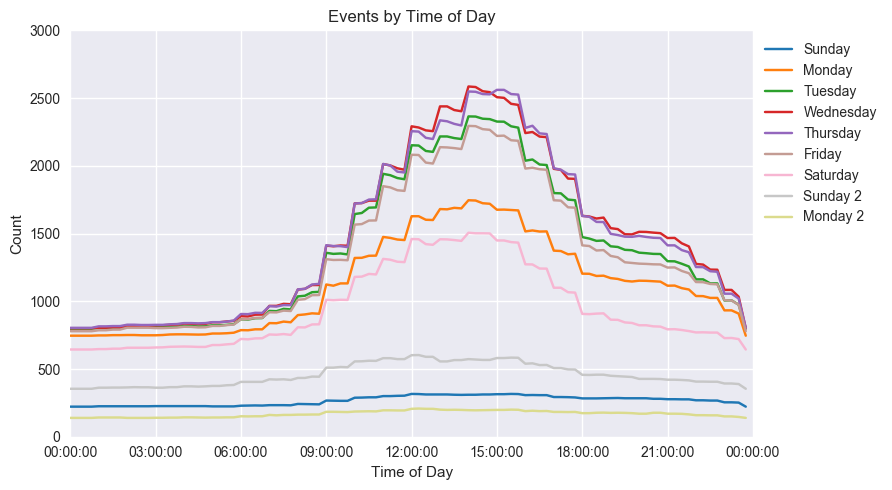

In [28]:
df_1 = construct_cumulative_times(df['Sunday'])
df_2 = construct_cumulative_times(df['Monday'])
df_3 = construct_cumulative_times(df['Tuesday'])
df_4 = construct_cumulative_times(df['Wednesday'])
df_5 = construct_cumulative_times(df['Thursday'])
df_6 = construct_cumulative_times(df['Friday'])
df_7 = construct_cumulative_times(df['Saturday'])
df_8 = construct_cumulative_times(df['Sunday2'])
df_9 = construct_cumulative_times(df['Monday2'])

start = 0.0;stop = 1.0;
number_of_lines = 10;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 5), dpi=100);

axes1 = fig.add_subplot(111);

axes1.plot(df_1['time'], df_1['count'], color=colors[0], ls='-');
axes1.plot(df_2['time'], df_2['count'], color=colors[1], ls='-');
axes1.plot(df_3['time'], df_3['count'], color=colors[2], ls='-');
axes1.plot(df_4['time'], df_4['count'], color=colors[3], ls='-');
axes1.plot(df_5['time'], df_5['count'], color=colors[4], ls='-');
axes1.plot(df_6['time'], df_6['count'], color=colors[5], ls='-');
axes1.plot(df_7['time'], df_7['count'], color=colors[6], ls='-');
axes1.plot(df_8['time'], df_8['count'], color=colors[7], ls='-');
axes1.plot(df_9['time'], df_9['count'], color=colors[8], ls='-');

axes1.set_xlim(0, df_1['time'].values[-1])
axes1.set_ylim(0, 3000)
axes1.set_xticks(np.arange(0, 90000, 10800))
axes1.set_xlabel('Time of Day')
axes1.set_ylabel('Count')
axes1.set_title('Events by Time of Day')
axes1.legend(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday 2', 'Monday 2'], 
             loc='upper right', bbox_to_anchor=(1.2, 1));

fig.tight_layout();

<a id='eventtimetypedist'></a>
# Events by Time of Day, by Type

Unsurprisingly, workshops tend to occur in the middle of the day and parties later at night. Interestingly, some events have a bimodal distribution. Peak party times are 6 PM and 9 PM. Performances peak around 4 PM and 9 PM.

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 753.67it/s]


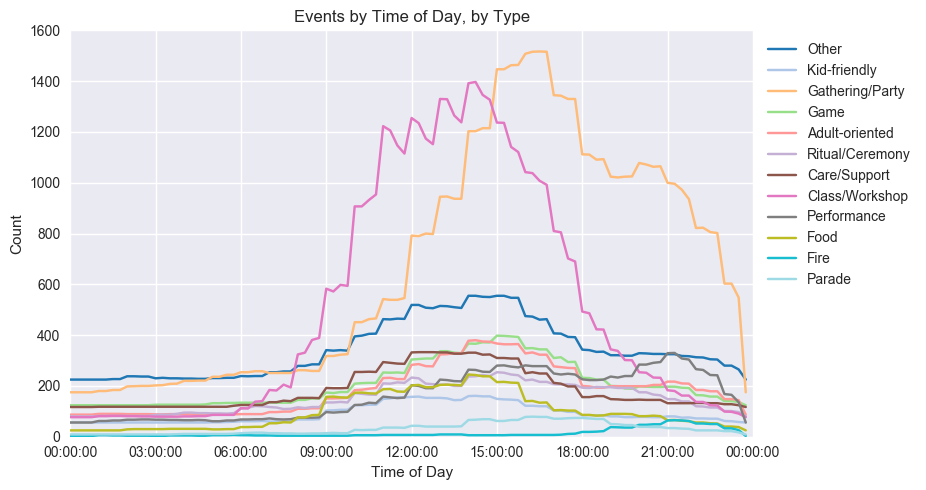

In [192]:
df['Merged Times'] = df['Sunday'].replace('0', np.nan).fillna(df['Monday']).replace('0', np.nan).fillna(df['Tuesday']).replace('0', np.nan).fillna(df['Wednesday']).replace('0', np.nan).fillna(df['Thursday']).replace('0', np.nan).fillna(df['Friday']).replace('0', np.nan).fillna(df['Saturday']).replace('0', np.nan).fillna(df['Sunday2']).replace('0', np.nan).fillna(df['Monday2'])

fig = plt.figure(figsize=(8, 5), dpi=100)

axes1 = fig.add_subplot(111)

event_types = df['Type'].unique()

start = 0.0
stop = 1.0
number_of_lines = len(event_types)
cm_subsection = np.linspace(start, stop, number_of_lines)
colors = [ cm.tab20(x) for x in cm_subsection ]

df_temp = construct_cumulative_times(pd.DataFrame()).drop(['count'], axis=1)

for i, event_type in enumerate(event_types):
    df_temp[event_type] = construct_cumulative_times(df[df['Type'] == event_type]['Merged Times'])['count']

for i, event_type in enumerate(event_types):
    axes1.plot(df_temp['time'], df_temp[event_type], color=colors[i], ls='-')

#for i, event_type in enumerate(event_types):
#    df_temp = construct_cumulative_times(df[df['Type'] == event_type]['Merged Times'])
#    axes1.plot(df_temp['time'], df_temp['count'], color=colors[i], ls='-')

axes1.set_xlim(0, df_temp['time'].values[-1])
axes1.set_ylim(0, 1600)
axes1.set_xticks(np.arange(0, 90000, 10800))
axes1.set_xlabel('Time of Day')
axes1.set_ylabel('Count')
axes1.set_title('Events by Time of Day, by Type')
axes1.legend(event_types, loc='upper right', bbox_to_anchor=(1.25, 1))

fig.tight_layout()

Here too we can run a t-test analysis to determine these differences. Unsurprisingly, parties are the most divergent from the other events, tending to occur much later in the day. Performances, fires, and parades also deserve an honorable mention (actually, all three of these types of events can be thought of as performances in a sense).

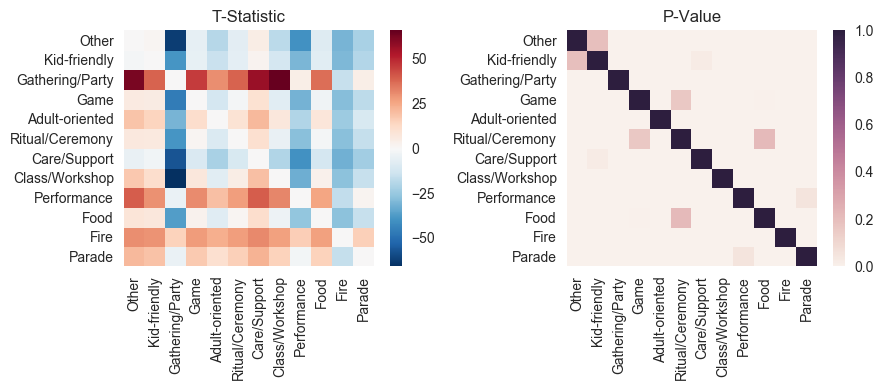

In [213]:
event_types = df['Type'].unique()

num = len(df_temp['time'].values)

dists = {}

for event_type in event_types:
    dist = []
    for i in range(num):
        dist += [i]*df_temp[event_type].values[i]
    dists[event_type] = dist
    
t = np.zeros((12, 12))
p = np.zeros((12, 12))

for i in range(len(event_types)):
    for j in range(len(event_types)):
        tt = ttest_ind(dists[event_types[i]], dists[event_types[j]], equal_var=False)
        
        t[i, j] = tt[0]
        p[i, j] = tt[1]
        
fig = plt.figure(figsize=(9, 4), dpi=100)

axes1 = fig.add_subplot(121)
axes2 = fig.add_subplot(122)

sns.heatmap(t, annot=False, ax=axes1, xticklabels=event_types, yticklabels=event_types)
sns.heatmap(p, annot=False, ax=axes2, xticklabels=event_types, yticklabels=event_types)

axes1.set_title('T-Statistic')
axes2.set_title('P-Value')

fig.tight_layout()

<a id='repeatevents'></a>
# Number of Repeated Events

About 5000 events (25% of the total) are repeated throughout the week. Most occur either twice, or five times (likely indicating Monday through Friday).

In [772]:
repeats = (df['Sunday'] != '0').astype(int) + (df['Monday'] != '0').astype(int) + (df['Tuesday'] != '0').astype(int) + (df['Wednesday'] != '0').astype(int) + (df['Thursday'] != '0').astype(int) + (df['Friday'] != '0').astype(int) +(df['Saturday'] != '0').astype(int)  + (df['Sunday2'] != '0').astype(int)  + (df['Monday2'] != '0').astype(int)

print("Total Number of Repeated Events: " + str(len([repeat for repeat in repeats if repeat > 1])))

Total Number of Repeated Events: 5126


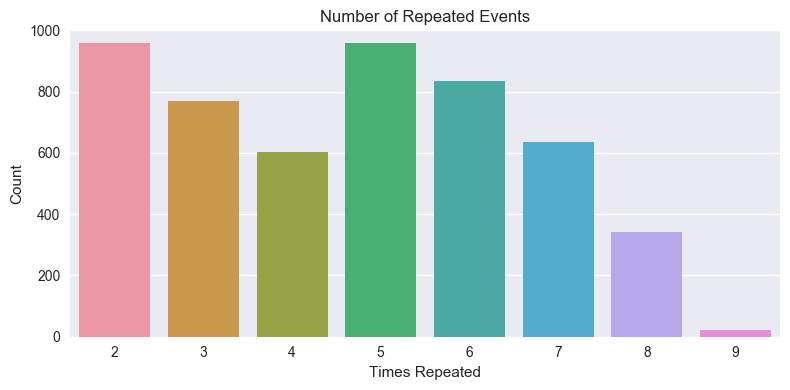

In [774]:
fig = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.countplot([repeat for repeat in repeats if repeat > 1], ax=axes1)

axes1.set_ylim(0, 1000);
axes1.set_xlabel('Times Repeated');
axes1.set_ylabel('Count');
axes1.set_title('Number of Repeated Events');

fig.tight_layout()

<a id='eventlength'></a>
# Event Length Distribution

Most events are 1-2 hours long, with numerous all-day-long events. There are also a substantial number of events  with negative lengths (about 6.7%) and zero (about 0.7%) lengths! Events with negative lengths are erroneous in different ways. Some could run all day, like the Bad Idea Bar. Some could be running from, say Sunday at 10 PM to Monday at 2 AM, and therefore appear negative in the simplistic calculation.

Note that in this calculation repetitions of events are counted seperately. 

In [15]:
times_1 = pd.DataFrame(get_time_diff(df['Sunday']),    columns=['Event Length'])
times_2 = pd.DataFrame(get_time_diff(df['Monday']),    columns=['Event Length'])
times_3 = pd.DataFrame(get_time_diff(df['Tuesday']),   columns=['Event Length'])
times_4 = pd.DataFrame(get_time_diff(df['Wednesday']), columns=['Event Length'])
times_5 = pd.DataFrame(get_time_diff(df['Thursday']),  columns=['Event Length'])
times_6 = pd.DataFrame(get_time_diff(df['Friday']),    columns=['Event Length'])
times_7 = pd.DataFrame(get_time_diff(df['Saturday']),  columns=['Event Length'])
times_8 = pd.DataFrame(get_time_diff(df['Sunday2']),   columns=['Event Length'])
times_9 = pd.DataFrame(get_time_diff(df['Monday2']),   columns=['Event Length'])

times = times_1.fillna(times_2).fillna(times_3).fillna(times_4).fillna(times_5).fillna(times_6).fillna(times_7).fillna(times_8).fillna(times_9)

df['Event Length'] = times

print("Total Number of Events: " + str(len(times)))
print("Total Number of Events: " + str(len(times)))
print("Percentage of Events with Negative Lengths: " + str(len([time for time in times.values if time < 0])/len(times)))
print("Percentage of Events with Zero Length: " + str(len([time for time in times.values if time == 0])/len(times)))

100%|████████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 694704.10it/s]


Total Number of Events: 20165
Total Number of Events: 20165
Percentage of Events with Negative Lengths: 0.06714604512769651
Percentage of Events with Zero Length: 0.007141086040168609


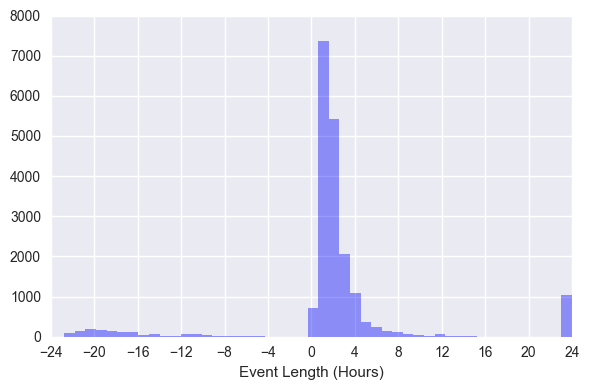

In [32]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.distplot(times, ax=axes1, kde=False, bins=48, color='blue', axlabel='Event Length (Hours)')

axes1.set_xlim(-24, 24)
axes1.set_ylim(0, 8000)
#axes1.set_yticks([])
#axes1.grid(False)
#axes1.set_facecolor('white')
#axes1.set_title('2015')
axes1.xaxis.set_major_locator(MultipleLocator(4))

fig.tight_layout()

Let's take a closer look at events with negative durations.

Event 6 and 69 seem to start at midnight, and have indefinite run times. These events should have lengths of 'NaN'

Event 69 cross from Monday at midnight into Tuesday at 4 AM. This issue could be solved by taking the absolute value of the length.

Many events with lengths of 0 effectively only have start times listed, and should also have lengths of 'NaN'

In [839]:
df[df['Event Length'] <= 0][df.columns[-9:]]

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Event Length
6,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,-0.25
69,midnight – 12:30 a.m.,0,0,0,0,0,0,0,-11.25
70,midnight – 4 a.m.,0,0,0,0,0,0,0,-19.75
71,midnight – midnight,0,0,0,0,0,0,0,0.00
72,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – 1 p.m.,0,0,0.00
74,midnight – midnight,0,0,0,0,0,0,0,0.00
75,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,0.00
76,midnight – midnight,0,0,0,0,0,0,0,0.00
77,midnight – 2:30 a.m.,0,midnight – 2:30 a.m.,0,0,0,0,0,-21.25
93,8:30 a.m. – 8:30 a.m.,0,0,0,0,0,0,0,0.00


<a id='eventlengthtype'></a>
# Event Length by Type

There does in fact appear to be a significant relationship between the event type and its typical length. Classes are the shortest, with mean average lengths of just under 2 hours and a median length of 1.5 hours. A party can run for a mean average of around 5.5 hours and median length of 3 hours, with a relatively long standard deviation of 5 hours! 

To improve the robustness of the the mean average statistic, we can remove the large group of outliers corresponding to 'All Day' long events. We also take the absolute value, to avoid nonsensical results caused by negative event lengths.

Examining the skenewss (1 corresponding to a Gaussian-like symmetric distribution) we see most events lengths are moderately skewed (towards shorter event lengths) while for some events (Food and Classes) the skew is extreme. Seems like food runs out quickly and people don't like to listen to lectures for very long!

In [40]:
df_events = pd.DataFrame(columns=['Event Type', 'Mean', 'Std Dev', 'Skew', 'Median', 'Mean (No All Day)', 
                                  'Std Dev (No All Day)', 'Skew (No All Day)', 'Median (No All Day)'])

for event_type in df['Type'].unique():
    stats          = describe(abs(df[df['Type'] == event_type]['Event Length'].values))
    stats_noAllDay = describe([time for time in abs(df[df['Type'] == event_type]['Event Length'].values) if time  < 23])
    
    df_events = df_events.append({'Event Type': event_type, 
                                  'Mean':                  stats.mean,
                                  'Std Dev':               stats.variance**0.5,
                                  'Skew':                  stats.skewness,
                                  'Median':                np.median(abs(df[df['Type'] == event_type]['Event Length'].values)),
                                  'Mean (No All Day)':     stats_noAllDay.mean,
                                  'Std Dev (No All Day)':  stats_noAllDay.variance**0.5,
                                  'Skew (No All Day)':     stats_noAllDay.skewness,
                                  'Median (No All Day)':   np.median([time for time in abs(df[df['Type'] == event_type]['Event Length'].values) if time  < 23])},
                                  ignore_index=True)
    
df_events.sort_values('Mean (No All Day)', ascending=False)

,Event Type,Mean,Std Dev,Skew,Median,Mean (No All Day),Std Dev (No All Day),Skew (No All Day),Median (No All Day)
2,Gathering/Party,5.582456,6.503645,1.722839,3.00,4.951919,5.634244,1.883754,3.0
4,Adult-oriented,6.061210,7.438988,1.530583,2.00,4.557618,5.545192,2.003042,2.0
10,Fire,4.743519,6.448226,1.852022,2.00,4.380503,5.933628,1.957148,2.0
0,Other,6.968156,8.584891,1.242118,2.00,3.767140,4.776032,2.368263,2.0
8,Performance,4.096371,6.256390,2.272483,2.00,3.354419,5.028704,2.675873,1.5
1,Kid-friendly,6.339715,8.143814,1.503199,2.00,3.121336,3.331332,2.563036,2.0
3,Game,5.646027,7.780141,1.739522,2.00,2.886529,3.370953,3.349299,2.0
6,Care/Support,6.136828,8.112327,1.584533,2.00,2.806619,2.733903,2.579819,2.0
11,Parade,3.479004,4.990452,3.149378,2.00,2.800551,3.362613,3.708277,2.0
9,Food,3.424025,4.891416,3.455633,2.00,2.791820,3.353910,4.526216,2.0


<a id='uniquecamps'></a>
# Number of Unique Camps Every Year

The number of unique camps has been steadily rising, from around 300 in 2009 to almost 600 in 2017. In total there have been over 2000 unique camps!

In [4]:
print("Total Number of Unique Camps = " + str(len(df['Hosted by Camp'].unique())))

Total Number of Unique Camps = 2137


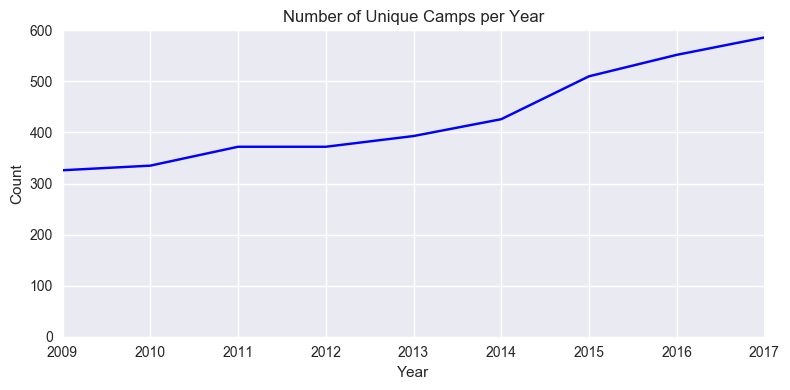

In [13]:
nmin = 150

start = 0.0;stop = 1.0;
number_of_lines = len(df['Year'].unique());
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111);

years = []
counts = []

for i, year in enumerate(df['Year'].unique()):
    years.append(year)
   
    counts.append(len(df[df['Year'] == year]['Hosted by Camp'].unique()))

axes1.plot(years, counts, color='blue', ls='-');

axes1.set_xlim(2009, 2017)
axes1.set_ylim(0, 600)
axes1.set_xlabel('Year')
axes1.set_ylabel('Count')
axes1.set_title('Number of Unique Camps per Year')

fig.tight_layout();

<a id='repeatedcampnames'></a>
# Repeated Camp Names?

There do seem to be some cases of the same camps listed numerous times with slight variations of the camp name.

For example, the entries 'Ashram Galactica', 'Ashram Galactica (The Grand Hotel)', 'Ashram Galactica Resort and Conference Center', and 'Ashram Galactica, The Grand Hotel' can all be assumed to be part of a single camp called 'Ashram Galactica'

In [27]:
camps = [str(camp) for camp in df['Hosted by Camp'].unique()]

print(sorted(camps))

['!Zoom!', '"House of Dust" does Gaia', '"Ignited States"', '&', '(My First) Period Bar', '(TMWC) The Rusty Hanger, BRC Sexual Wellness Clinic', "...and then there's only LOVE", '1.21 Gigawatts', "100'th Monkey Camp", '17 Virgins', '1st Bank of BRC', '2011KING OF CARNAVAL CAMP', '3SP (Third Space Place)', '7 Deadly Gins', '7 Sins Lounge', "7 Siren's Cove", '7 Sirens Cove', '8-bit Bunny', '88', '9 Energies', '9 Energies - Know Your Superpower', 'A Camp With No Name', 'A Camp with No Name (ACWNN)', 'A Cavallo Tribal Thunder', 'A Light Hazing Camp', 'A Shack Of Sit', 'A Shack of Sit', 'A Transformation Station', 'A-TickleTrunkTastic Camp', 'ABC - Alphabet Block Camp', 'ABC Alphabet Block Camp', 'ABR: Acronym Being Reconsidered', 'ANITA COCKTAIL', 'AO (Almost Orgy)', 'AOXOMOXOA', 'APOKILIPTIKA', 'AREOLA51', 'ART OF SUCH N SUCH', 'ARTery', 'AWESOMETOWN', 'Above The Limit', 'Above The Limit (ATL)', 'AbsoFuckinLution', 'Academy of Arts and Sciences', 'Academy of Fools', 'AdramaNation', 'Adult

We can use Fuzzy Matching to camps with very similar names.

In the case of Ashram Galactica, scores of 67+ correctly match, but miss the Resort and Conference Center

In [66]:
matches = fuzzywuzzy.process.extract("Ashram Galactica", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('Ashram Galactica', 100), ('Ashram Galactica (The Grand Hotel)', 65), ('Ashram Galactica, The Grand Hotel', 65), ('AdramaNation', 57), ('AstroPups Sirian Embassy Galactic', 57), ('Camp Atlantis', 55), ('Gaylactic Invaders', 53), ('Camp Gallavant', 53), ('Galactic Labyrinth', 53), ('asana-mania', 52)]


AstroPups are missed entirely

- AstroPups
- AstroPups Sirian Embassy Galactic
- AstroPups:Warp Station Alpha
- Astropups: Burying the Bone
- Astropups: Camp Pupawannahumpya
- Astropups:Defenders of Muttropolis
- AstroPup Labs:DogVinci's Workshop

In [67]:
matches = fuzzywuzzy.process.extract("AstroPups", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('AstroPups', 100), ('Astro Cats', 63), ('Bad Asstronauts', 58), ('Circus Metropolus', 54), ('Farmopolis', 53), ('Café S?rprïsé', 53), ('Mamasaurus', 53), ('Dust Circus', 50), ('Mobtropolis', 50), ('Astropups: Burying the Bone', 50)]


As well as BMIR, which occurs as:

- BMIR
- BMIR - Burning Man Information Radio 94.5 FM
- BMIR 94.5 FM
- BMIR, Burning Man Information Radio 94.5 FM
- BMIR-FM, Burning Man Information Radio 94.5

In [68]:
matches = fuzzywuzzy.process.extract("BMIR", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('BMIR', 100), ('Shibumi', 55), ('Wabi', 50), ('BMIR 94.5 FM', 50), ('Brûlée', 50), ('Backfire', 50), ('Bierdhaus', 46), ('MindShark', 46), ('BRC MoIST', 46), ('Miso Horny', 43)]


Barbie Death Camp doesn't too too bad. A score of 74 gets 4, although we still miss the Village.

In [69]:
matches = fuzzywuzzy.process.extract("Barbie Death Camp", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('BARBIE DEATH CAMP', 100), ('Barbie Death Camp', 100), ('Barbie Death Village', 76), ('Barbarian Camp', 71), ('Barbie Death Camp & Wine Bistro', 71), ('Barbie Death Camp & Wine Bistro ', 71), ('Barbie Day Spa', 71), ('Advice Booth Camp', 65), ('Rat Camp', 64), ('Back To Camp', 62)]


And just to see what kind of false positives we could get with common strings:

In [70]:
matches = fuzzywuzzy.process.extract("BRC", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('BRC3PO', 67), ('BRC HOA', 60), ('Brûlée', 57), ('BMIR', 57), ('FTB+C', 50), ('BRC MoIST', 50), ('T.B.C.', 50), ('BurnSecret', 46), ('Bounce!', 44), ('Brulee', 44)]


In [71]:
matches = fuzzywuzzy.process.extract("Playa", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('Playagon', 77), ('Playa 54', 77), ('Playatel', 77), ('PLAYA 54', 77), ('¡Playasos!', 77), ('PlayaTune', 71), ('Playa Info', 67), ('PlayaNauts', 67), ('PlayaSkool', 67), ('Playasophy', 67)]


In [72]:
matches = fuzzywuzzy.process.extract("Spank", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('Spank Bank', 67), ('Otis Spankmore', 53), ('nan', 50), ('Pandora', 50), ('SNO*PAC', 50), ('Sexagon', 50), ('Speakcheasy', 50), ('Jipangu', 50), ('Sextant', 50), ("Spanky's Village", 48)]


Unfortunately it doesn't look like any simple fuzzy-matching can solve this problem. We'll need to dig deeper into the fuzzy match scoring to see if we can figure this one out.

<a id='mostactivecamps'></a>
# Who are the most active camps?

Across the years, the Sacred Spaces Village, by far, has been most active in posting their events into the schedule. Although given the fuzzy matching issue, it is possible that other, less consistently named camps, may in reality be further ahead in the rankings.

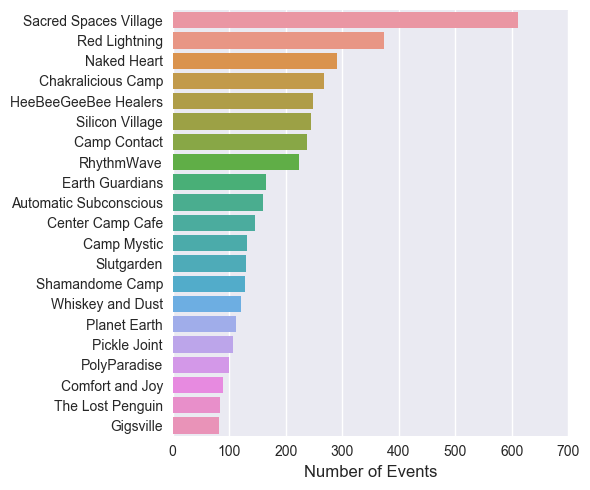

In [36]:
camp_count = df['Hosted by Camp'].value_counts().reset_index();

camp_count = camp_count[camp_count['index'] != '-'];

camp_count_filtered = camp_count[camp_count['Hosted by Camp'] > 80];

fig = plt.figure(figsize=(6, 5), dpi=100);

axes1 = fig.add_subplot(111); 

sns.barplot(x='Hosted by Camp', y='index', data=camp_count_filtered, ax=axes1);

axes1.set_xlim(0, 700);
axes1.set_ylabel('');
axes1.set_xlabel('Number of Events', size=12);
axes1.tick_params(axis='both', which='major', labelsize=10);

fig.tight_layout();

Looking at the event count per year of the most active camps, we can see that the most active camp, Sacred Spaces, had participation sharply drop to zero after 2013, indicating Camp Death. Naked Heart, on the other hand, has been steadily rising in 2012 and should be a big presence this coming year.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


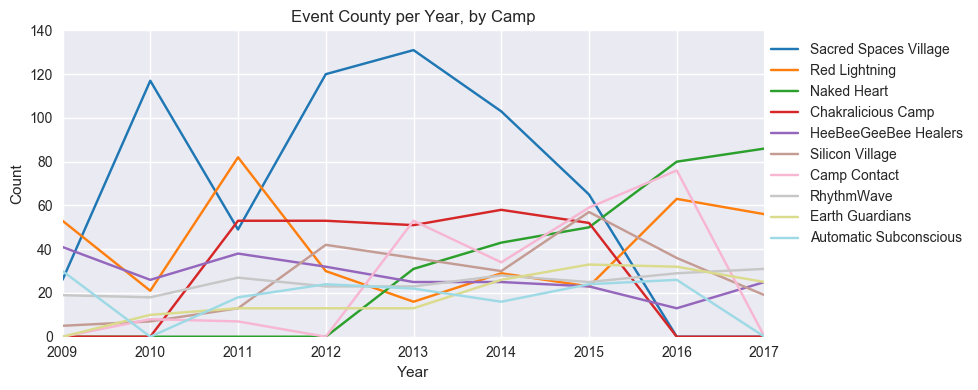

In [873]:
nmin = 150

start = 0.0;stop = 1.0;
number_of_lines = len(camp_count[camp_count['Hosted by Camp'] > nmin]['index'].values);
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111);

for i, camp_name in enumerate(camp_count[camp_count['Hosted by Camp'] > nmin]['index'].values):
    years = []
    count = []

    for year in df['Year'].unique():
        years.append(year)

        count.append(len(df[df['Year'] == year][df['Hosted by Camp'] == camp_name]))
    
    axes1.plot(years, count, color=colors[i], ls='-');


axes1.set_xlim(2009, 2017)
axes1.set_ylim(0, 140)
axes1.set_xlabel('Year')
axes1.set_ylabel('Count')
axes1.set_title('Event County per Year, by Camp')

axes1.legend(camp_count[camp_count['Hosted by Camp'] > nmin]['index'].values, loc='upper right', bbox_to_anchor=(1.3, 1));

fig.tight_layout();

<a id='camplifespan'></a>
# Camp Lifespans

As a proxy for camp lifespan, we can measure the number of years in which a camp contributes events. It looks like most only show up for a single year, with an exponential dropoff. We should take this with a grain of salt though, due to the camp name variablity issue discussed previously. 

Overlaid is the expected behavior of a Poisson process. Note the faster initial dropoff with the heavier tail in the actual data. This means that the return rate parameter within the Poisson process is not constant. It's smaller for younger camps and larger for older camps. Many camps won't make it into their second year, but if they do, they're likelier to have a long life.

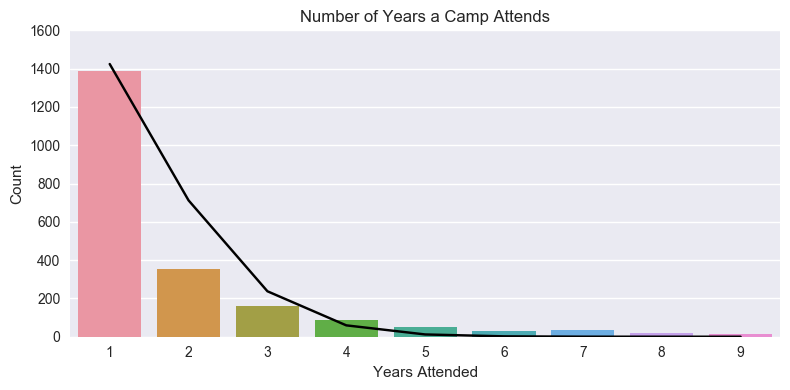

In [273]:
camp_attendance = {}

for year in df['Year'].unique():
    unique_camps = df[df['Year'] == year]['Hosted by Camp'].unique()
    
    for camp in unique_camps:
        if camp in camp_attendance.keys():
            camp_attendance[camp] += 1
        else:
            camp_attendance[camp] = 1
            
fig = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.countplot([*camp_attendance.values()], ax=axes1)

axes1.plot(np.arange(9), (stats.poisson.pmf(np.arange(10), mu=1)*np.array([*camp_attendance.values()]).sum())[1:], 'black')

axes1.set_ylim(0, 1600);
axes1.set_xlabel('Years Attended');
axes1.set_ylabel('Count');
axes1.set_title('Number of Years a Camp Attends');

fig.tight_layout()

<a id='eventdescriptions'></a>
# Let's take a look at the event descriptions

The mean-average length of an event description is approximately 50 words with 300 characters. 

In [304]:
# Convert Dataframe Column to a joined array of strings
text = ' '.join(list(df.Description.values.astype(str))).lower().replace('\n', '').replace('\r', '');

# How many words in total are there?
print('Character Count = ' + str(len(text)));
print('Mean Average Character Count = ' + str(len(text)/len(df.Description.values)));

print('Total Word Count = ' + str(len(text.split())));
print('Mean Average Word Count = ' + str(len(text.split())/len(df.Description.values)));

Character Count = 5999673
Mean Average Character Count = 297.5290354574758
Total Word Count = 1015532
Mean Average Word Count = 50.36112075378131


Looking at a character distribution plot however, we see that the distribution is peaked at just over 100 characters and is highly skewed. The overlaid fit of a Gamma distribution looks great at the tails, just don't look at that spike! Something about the 100-150 character length is very popular, it could be the officially recommended event description length.

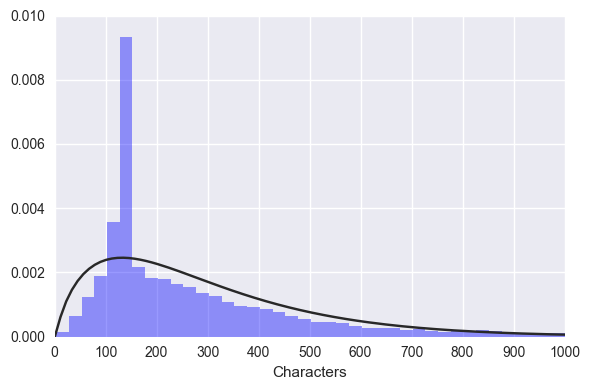

In [321]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.distplot([len(event) for event in list(df.Description.values.astype(str))], ax=axes1, 
             kde=False, bins=80, fit=stats.gamma, color='blue', axlabel='Characters')

axes1.set_xlim(0, 1000)
axes1.set_ylim(0, 0.01)
#axes1.set_yticks([])
#axes1.grid(False)
#axes1.set_facecolor('white')
#axes1.set_title('2015')
axes1.xaxis.set_major_locator(MultipleLocator(100))

fig.tight_layout()

In [610]:
count_vect_desc  = CountVectorizer(stop_words='english', min_df=100, ngram_range=(1, 3), analyzer='word')

X = count_vect_desc.fit_transform(events['Description'].values);

In [323]:
tokenizer = RegexpTokenizer(r'\w+');

event_fdists = []

for event_type in tqdm(event_types):
    event_text = ' '.join(list(df[df['Type'] == event_type]['Description'].values.astype(str))).lower().replace('\n', '').replace('\r', '')
    
    event_tokens = tokenizer.tokenize(event_text);

    event_Text = nltk.Text(event_tokens)
    
    event_filtered_words = [word for word in event_Text if word not in stopwords.words('english')];

    event_filtered_words = [word for word in event_filtered_words if len(word) > 3];

    event_fdist_filtered = nltk.FreqDist(event_filtered_words);
    
    event_fdists.append(event_fdist_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:12<00:00, 21.07s/it]


In [650]:
most_common_df = pd.DataFrame()

for event_type, event_fdist in zip(event_types, event_fdists):
    print(event_fdist)
    most_common_df[event_type] = [word[0] for word in event_fdist.most_common(40)]

<FreqDist with 8637 samples and 34478 outcomes>
<FreqDist with 3455 samples and 10590 outcomes>
<FreqDist with 17360 samples and 128875 outcomes>
<FreqDist with 5845 samples and 23542 outcomes>
<FreqDist with 6135 samples and 36214 outcomes>
<FreqDist with 7221 samples and 31135 outcomes>
<FreqDist with 5039 samples and 18780 outcomes>
<FreqDist with 17499 samples and 168162 outcomes>
<FreqDist with 9777 samples and 44849 outcomes>
<FreqDist with 4775 samples and 18989 outcomes>
<FreqDist with 1894 samples and 4312 outcomes>
<FreqDist with 2991 samples and 10028 outcomes>


Surprise surpise. The most common word in "Fire" events is... fire! 

"Come" is common all-around, as well as "playa" for that matter, and should be considered a stopword, along with "join".

Then "game" becomes the most common word for "Game" events. 

Likewise kid-friendly events have "kids" as the 4th most common word. And "Gathering/Party" events have "dance, party, music" as common words.

In [651]:
most_common_df

,Other,Kid-friendly,Gathering/Party,Game,Adult-oriented,Ritual/Ceremony,Care/Support,Class/Workshop,Performance,Food,Fire,Parade
0,come,come,come,come,come,come,come,come,come,come,fire,playa
1,playa,camp,playa,game,play,playa,playa,learn,playa,playa,come,join
2,camp,playa,party,playa,bring,join,camp,bring,music,bring,spin,camp
3,bring,kids,dance,play,playa,bring,healing,body,show,coffee,bring,parade
4,join,bring,join,camp,experience,ceremony,help,playa,live,camp,fuel,meet
5,like,black,bring,bring,safe,love,body,yoga,join,enjoy,burn,march
6,music,rock,music,join,open,ritual,need,dance,bring,join,join,bring
7,time,make,camp,games,partner,temple,bring,experience,stage,pickle,night,come
8,dance,city,night,prizes,learn,life,massage,join,camp,cold,playa,around
9,take,take,enjoy,time,space,dance,open,workshop,rock,food,burning,black


Let's take a look at common text bigrams and trigrams with the nltk package

In [324]:
# Convert strings to nltk "token" objects
tokenizer = RegexpTokenizer(r'\w+');

tokens = tokenizer.tokenize(text);

# Convert tokens into an nltk "Text" object
Text = nltk.Text(tokens);

# Filter out stop words
filtered_words = [word for word in Text if word not in stopwords.words('english')];

# Filter out short words
filtered_words = [word for word in filtered_words if len(word) > 3];

fdist_filtered = nltk.FreqDist(filtered_words);

# n-gram measures 
bigram_measures  = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

finder_bigram  = nltk.BigramCollocationFinder.from_words(filtered_words)
finder_trigram = nltk.TrigramCollocationFinder.from_words(filtered_words)

In [353]:
finder_bigram.nbest(bigram_measures.raw_freq, 10)

[('black', 'rock'),
 ('rock', 'city'),
 ('come', 'join'),
 ('come', 'learn'),
 ('happy', 'hour'),
 ('dance', 'party'),
 ('center', 'camp'),
 ('come', 'play'),
 ('live', 'music'),
 ('feel', 'free')]

In [349]:
finder_trigram.nbest(trigram_measures.raw_freq, 10)

[('black', 'rock', 'city'),
 ('feel', 'free', 'bring'),
 ('first', 'come', 'first'),
 ('photography', 'drugs', 'alcohol'),
 ('black', 'rock', 'desert'),
 ('burning', 'stays', 'burning'),
 ('happens', 'burning', 'stays'),
 ('center', 'camp', 'cafe'),
 ('come', 'first', 'served'),
 ('mind', 'body', 'spirit')]

For easy visualization, create a word cloud of the most common words in event descriptions.

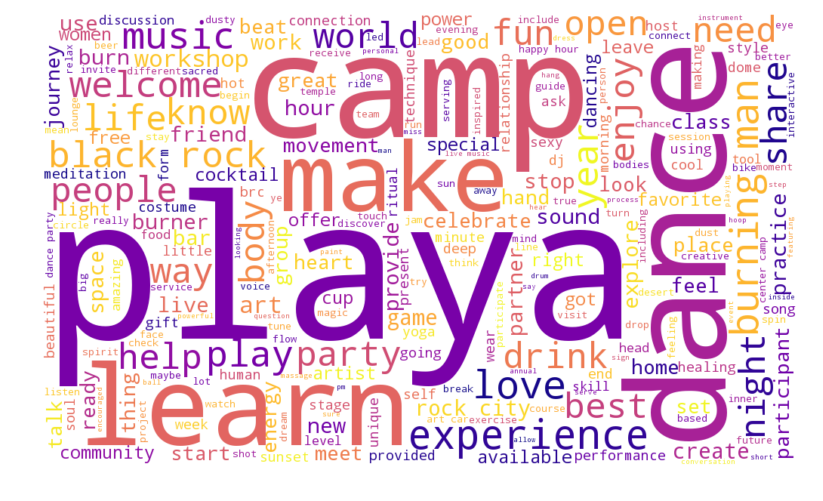

In [155]:
limit = 250
bgcolor = '#FFFFFF'
specific_stopwords = ['nan', 'come', 'bring', 'join', 'let', 'daily', 'nthe', 'let', 'event', 'want', 'time', 'dj', 'day']
english_stopwords = set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(specific_stopwords)

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'plasma'
).generate(text)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

<a id='visualizeeventtitles'></a>
# Visualize Event Titles

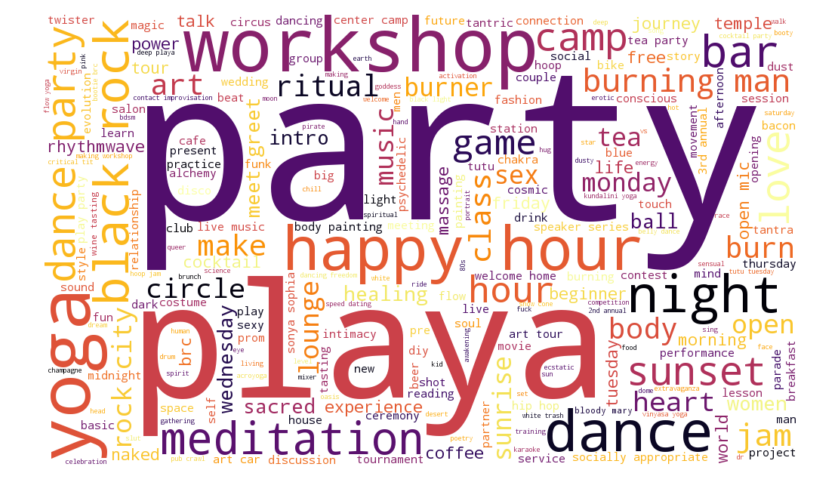

In [89]:
text = ' '.join(list(df['Title'].values.astype(str))).lower().replace('\n', '').replace('\r', '');

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'inferno'
).generate(text)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

<a id='visualizecampnames'></a>
# Visualize Camp Names

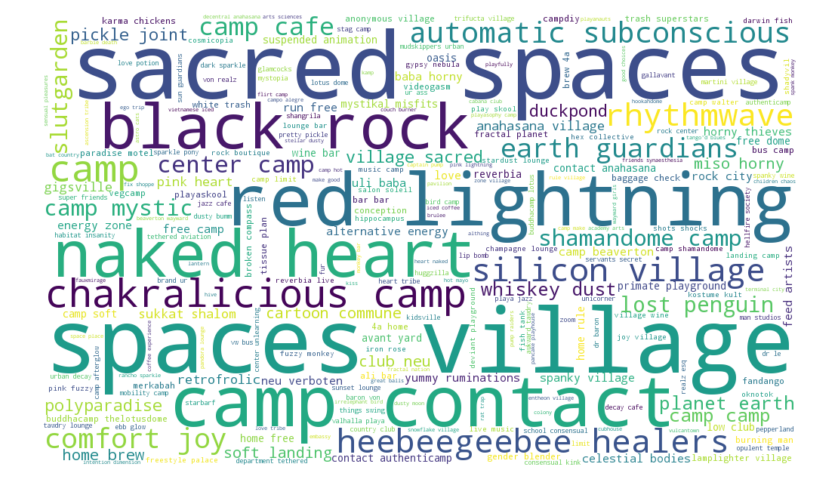

In [91]:
text = ' '.join(list(df['Hosted by Camp'].values.astype(str))).lower().replace('\n', '').replace('\r', '');

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'viridis'
).generate(text)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

<a id='sentiment'></a>
# Sentiment Analysis

Let's run a quick sentiment analysis with NLTK's VADER algorithm. 

Looks like the overall sentiment score is close to neutral and slightly positive.

If we look at the distribution of scores by event, we see that the descriptions are definitely not negative, only a little positive, and with a large degree of neutrality. The compound score is positive-leaning, but with a large peak near zero.

...although perhaps we shouldn't put too much stock on this particular sentiment analysis. Burners enjoy wordplay, snark, and have their own slang, which may not be adequatly captured.

The beta-distribution fit indicates the presence of "un-natural" spikes at extreme values (-1, 0, 1).

In [322]:
sia = SIA();

polarity_scores = [sia.polarity_scores(str(event)) for event in df.Description.values];

overall_polarity = sia.polarity_scores(' '.join(df.Description.values))

print('Overall Polarity Scores: ' + str(overall_polarity));

Overall Polarity Scores: {'neg': 0.049, 'neu': 0.748, 'pos': 0.203, 'compound': 1.0}


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


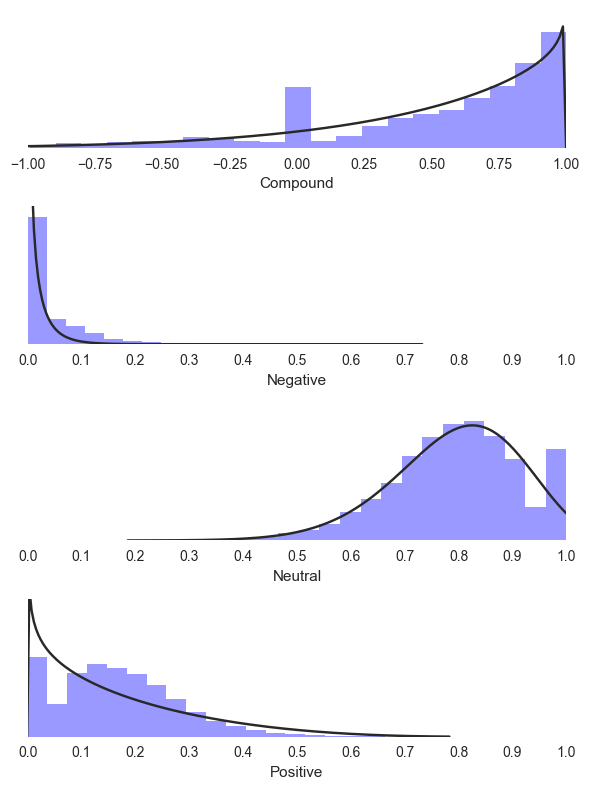

In [355]:
fig = plt.figure(figsize=(6, 8), dpi=100);

axes1 = fig.add_subplot(411); axes2 = fig.add_subplot(412);   axes3 = fig.add_subplot(413);   axes4 = fig.add_subplot(414); 

sns.distplot([event['compound'] for event in polarity_scores], ax=axes1, kde=False, bins=21, color='blue', fit=stats.beta, axlabel='Compound')
sns.distplot([event['neg']      for event in polarity_scores], ax=axes2, kde=False, bins=20, color='blue', fit=stats.beta, axlabel='Negative')
sns.distplot([event['neu']      for event in polarity_scores], ax=axes3, kde=False, bins=20, color='blue', fit=stats.beta, axlabel='Neutral')
sns.distplot([event['pos']      for event in polarity_scores], ax=axes4, kde=False, bins=20, color='blue', fit=stats.beta, axlabel='Positive')

axes1.set_xlim(-1, 1);
axes2.set_xlim(0, 1);
axes3.set_xlim(0, 1);
axes4.set_xlim(0, 1);

axes1.set_ylim(0, 2.5);
axes2.set_ylim(0, 20);
axes3.set_ylim(0, 4);
axes4.set_ylim(0, 7);

axes1.set_yticks([]);axes2.set_yticks([]);axes3.set_yticks([]);axes4.set_yticks([]);

axes1.grid(False);axes2.grid(False);axes3.grid(False);axes4.grid(False);

axes2.xaxis.set_major_locator(MultipleLocator(0.1))
axes3.xaxis.set_major_locator(MultipleLocator(0.1))
axes4.xaxis.set_major_locator(MultipleLocator(0.1))

axes1.set_facecolor('white');axes2.set_facecolor('white');axes3.set_facecolor('white');axes4.set_facecolor('white');

fig.tight_layout()

<a id='locations'></a>
# How are event locations distributed?

The Area Known as Burning Man is referred to as Black Rock City by the natives. It has a circular structure consisting of radials with clock-like names, and arcs with alphabetical names.

![](images/Map.jpg)

Let's look at what event locations look like. Some look like Camp Names. Some are mappable locations like '5:45 & G'. Some are erroneous entries of emails and websites. Others seem like total nonsense.

In [77]:
[location for location in df[df['Year'] == 2017]['Location'].values if not pd.isnull(location)]

['citizenmeow',
 'Camp Beaverton',
 '8:15 & D',
 'sick.jon@gmail.com',
 'Wandering all over BRC',
 'wolfcub',
 'rangerlightchaser@gmail.com',
 'Court Yard at Comfort & Joy Village',
 'Court Yard at Comfort & Joy Village',
 'citizenmeow',
 'Court Yard at Comfort & Joy Village',
 'Pink Gym at Comfort & Joy Village',
 'Pepperland',
 '6:45 Dance',
 'Anahasana Village',
 'Center Camp Cafe Performance Stage',
 'in Tiara at Comfort & Joy Village',
 'Pepperland',
 'Camp Settle This Like Men',
 'Camp Settle This Like Men',
 'dillowsky',
 'On 4:30 and D',
 "The Camp for Sensual Pleasures in Spanky's Village and Wine Bar",
 "The Camp for Sensual Pleasures in Spanky's Village and Wine Bar",
 'lifeinflow',
 'Center Camp',
 'At Valhalla on the Playa camp',
 'minstrelcramp',
 'Plaza at 4:30 or 7:30',
 'The Black Rock Beacon is located at Iron Rose this year.',
 'Power Room at Comfort & Joy Village',
 'beth.pferd@gmail.com',
 'SNAP Camp + Cafe',
 'VoiceOfReason',
 'Camp Settle This Like Men',
 'Maripo

<a id='others'></a>
# the Others

Interactive art events. Informational events. Events that sound like they're parties or performances, but weren't labeled so.

In [101]:
for description in df[df['Type'] == 'Other']['Description'].values:
    print(description)
    print('\n')

“Check Your Baggage” on PLEASair’s giant mocked-up luggage! Write your problems on suitcases that’ll be burned at the Temple… then join the Captain for a cup of our famous Jet Fuel!


Check out the Annoying Phone Booth while E.T and Superman aren’t here.


Brand-UR-Ass 'N More will stimulate your entire being, from your mind to your ass. Bare your butt at the hitchin post and get a fun temporary brand, your soul to our Speedtherapist, your spirit to the sound healer, and quench your thirst at the Martini Bar. Y'all come and play!


Stock up on safer sex preparedness equipment 24/7


Beautiful limited edition porcelain figurine for each of the first 32 couples getting married at Burning Man. Come to the Wedding Reception hosted by Armadillo or ask for Janice at The Lost Penguin Cafe


Check out how burners are taking ethos from BRC and bringing it to the world. BRAF, BRS, BWB, and Regionals will host an interactive art experience.


Come enjoy a ride on the Chairway to Heaven tower, the

Center Camp - Open Capoeira roda for everyone. Open to all ages, levels, styles. Bring instruments if you have them, come with good energy, good axé, and plenty of water! Vem jogar camará!


For all you cougars out here on the Playa. Greg will show you the kiss of a lifetime, as he is in fact a professional. Limit, one kiss per M.I.L.F.


Come sip a chilled vodka or enjoy another beverage of your choice around the Potato Lounge. Carbohydrate-laden snacks provided.


Join others in Recovery for a nightly ride around the city.


The worst in Psychotronic B-movie Disentertainment available. Libations start at 2 p.m., toxic cinema starts at sundown.


Enter the intersection at your own risk, the Crazy Stop Light controls all who venture near...


Monday a very special burning man style milonga.  Intro class 9-10 PM! Music of all kinds for great social dancing.


Chill out at our big, bright video screen! We're screening classic movies long and short, our personal playa videos, & music with

*Learning and creating chants for healing and self-expression


Like tubberwear, but instead we are silk screening.


Come learn about Reiki in the Evolutionary Temple.


Winner of six film festival awards for best documentary, The Witness tells the story of Eddie Lama, a tough construction contractor from Brooklyn whose chance encounter with a kitten completely transforms his life.  "May be the most important and persuasive film about animals ever made." - LA Times.  Film screening and discussion.


We are passing around cute stuffies squid at the door to maim, kick and throw about in frustration of all your beautiful plans and dreams of burning man or your life in general being thwarted by evil doers.  Take your aggressions out in this perfectly legal event set to hard, pounding and angry goth music.  Anyone happening upon or owning a squid may bring it by for a proper kicking.


If you're a goth, or wanna be goth, then you'll want to be at Planet Earths wednesday night Goth Club for

Narrated by Joaquin Phoenix, Earthlings is the most comprehensive film ever produced about the relationship between humans, nature, and animals. "Absolutely Epic" – John Feldmann (musician Goldfinger). Film screening and discussion.


Child of the 80s? You won't want to miss Planet Earths special Friday Night Videos, come get your dance on to all the top MTV & FNV hits from the 80s.


Dance the fishbug dance at the most primordial sculpture on the playa.  Lessons will be given, and prizes awarded for the best jitter.


30 minute countdown at 9:30 PM, launch at 10 PM.



Join the intrepid crew of the Raygun Gothic Rocketship for our first post retro-fit launch. Following consultations with engineers and  

scientists from around the world, we're going to test our revolutionary new Uira engines, designed to carry us further, faster & beyonder than ever before!



Under command of test pilot Gus Gristle, we plan to make a short flight, before loading provisions and equipment for our true 

Tonight's movie theme is 70's cheesy musicals!  Movies start at 9pm: Sgt Pepper's, Xanadu


Your blinky lights running out of juice? Bring your charger and rejuvenate them at Salon Soleil's solar-powered battery recharging station.


A new action packed sport played with a giant yoga ball. Won Best Sport of 2009 at New York's Come Out and Play Festival. Be one of the first in the world to play the sport that will take the 2032 Olympics by storm! Easy to learn, fun to play. Free rule books and other goodies for all comers


Welcome to the Litter Box of Boo Boo Kitty. Partake in the adventure of prowling, clawing, and marking your territory riding along Boo Boo Kitty.


Creative body printing and painting using handmade stamps and brush work. Stop by and relax with us while we turn your body into art.


The V-SPoT~~Volunteer Here! YES, YOU CAN STILL VOLUNTEER AT BURNING MAN! NO, you didn't have to sign up in advance! WE NEED YOU! Stroll over to Playa Info in Center Camp. Just inside, you

http://www.youtube.com/user/carefactornil71#p/u


Come witness true magic as the wizards of Arc Attack catch lightning with their very hands, bending it their will to make music with a thrilling beat!


It's not like you have to pack it out or anything. You don't even have to go down the block with a spare roll of toilet paper. Just do it right where you are. It's time to celebrate our farts and acknowledge that it's about time we got over that harmless smell. What's the big deal? You're human for christsake! Today you can feel free to fart any old time as loudly and as smellily as you want!


A fast-food company executive learns what really goes into his company's food. Film screening and discussion.


The Burning Man Ultramarathon will be a true test for the hardcore runners: in the desert, in the middle of the crazy, wonderful, hot, sandy, sweaty Burning Man festival, runners will face a series of loops around the perimeter, past The Man and The Temple, past various artwork, through

In the 5Rhythms we dance hard, we dance bold, we dance deep. Jonathan takes us to the place where the soul of hip hop, the catharsis of rock and roll, the trance of techno and the heart of house collide into the world beat. And in this beat, we get together to reinvent ourselves, to discard last week’s fears and move into this week’s dreams. This is our practice. It doesn’t matter where we come from or how we grew up or whether we can or can’t dance. Movement is medicine, and whether we feel clumsy or graceful, it heals us. Real learning happens when we show up and move because the body can’t lie. It lets us know right away if we’re feeling closed or open, fixed or fluid, tight or loose, off or on. We carry so many things, and not just in our backpacks. What do we do with all this repressed stuff, the headtrips that are holding us back, holding us down, and turning us into something we’re not? We dance. We dance with whatever’s going on inside of us and connect with others who are doin

As with many of the original kits, the artist's intention is to complete this artwork with fire after the man burns.


Pee Funnel Camp dispenses Pee Funnels at two convenient locations serving Black Rock City all day and all night!  Pee Funnels allow ladies to easily stand and pee or aim into a jug. No more exhausting and cold visits to the port-a-potty during the night - pee in a bottle and dump it in the morning!  PLEASE EMPTY YOUR PEE BOTTLES!  YOU MAKE US LOOK BAD IF YOU DO NOT! Visit our 2nd Pee Funnel Dispenser near the 9:00 and E port-a-potties - or come visit us on the other side of the city (check any port-a-potty for our address) and help us celebrate our 10th year as Pee Funnel Camp!  We put the fun in Pee Funnel!  Stand Free and Pee!


At Rites of Zion enter Principia Elemental and immerse yourself in contemplation of the Ten Principles of Burning Man.  Having considered this great foundation, record your own thoughts and inspirations on what would be the Eleventh Principle

What time is it?  Adventuretime.


Who doesn't need a good cuddle sometimes?  Come on over to CouchBurners Camp, where you're welcome to jump into the Cuddle Puddle Snuggle Pool with a friend or two.  Or six.  There are lots of pillows, blankets, and snugglies to keep you comfy and relaxed.  



Take a load off Annie... Take a load for free.


Need to practice a language? Wanna improve an accent? Learn some new words? Want to share your own language? We are international Burners from the CouchSurfing community that speak Spanish, French, Italian, Hebrew, German, piglatin, Portuguese, Russian,  Dutch, etc. Stop by and see who is around lounging on our Mutant Sofa and chat it up!


We're celebrating our Mutant Sofa's return for year 5 @ Black Rock City.  It was frankensteined together specifically to be surfed from CouchSurfers from all over the world, and is posted at CouchBurners Camp under the Darth Shader.  Come try it out, take a load off, make new friends, and watch some internatio

We've also setup a mobile sno-cone crew to ride around the playa bringing sno-cones into people's camps.  We're outfitting them with an old timey "ice cream man" sound setup and we will be hunting for Burners in need of icy goodness.


One world currency camp is hosted by Joshua and the 1worldcurrency.net network. Join us in overturning the money changers tables.



1worldcurrency.net is a hub for a network of creators whose mission is the creation of a secure, ecologically sustainable, resource based, electronic, open source, transparent, interest free, fee free, money system / medium of exchange created by the people, for the people, available to every human on the Earth.



Take the technology and set ourselves free of usury.



1worldcurrency.net is a time, technology, and global resource exchange network and platform capable of exchange in thousands of different community currencies and interest free economies. It is a global language or alchemical solvent capable of delivering gl

The first ever Segway party on the playa!  Ride your two wheels of glory in for cocktails and celebrate the future of personal transport. Jousting ok.


The first 20 hot travelers are welcome to relax on our patio, share your Burning Man stories, and enjoy a cool Poinsettia.


We have tulle! Come learn how to make a fabulous tutu and prance around like fairies with us. It's the center for unlearning. All fairies welcome! Fuck what you know!


Come one, come all, to the Pinkest Happy Hour on the Playa!  Camp Walter will be serving up Prickly Pink Margaritas in our World Lounge from 4:30pm until we run out!  Special treats will be given to the Pinkest People on the Playa, so don your finest of hot pink wares, and join us for some hot and pinky fun!


Tesla is the master of driving anything with or without wheels. Bring your motorized anything and she will show you the tricks of the trade. Anything acceptable. Art Car assistance and Golf Cart Lessons. Or just sit back and let her take you

Come In white, come in your greatest white trash/redneck outfit (especially if its your finest mustard stained wife beater), or just show up & Party with us superstars.


Reverbia At Night presents Live Music Concerts from National and Regional touring acts... featuring Latin, World, Reggae, Hip Hop, Experimental Rock, and more.  Come and join the growing number of Live Music Burners, who love to dance and listen to live music.  Visit our facebook page to see which Artists will be performing on our outdoor stage. TBA. Thursdays are Latin night.


Our crew of expert riggers and performers will demonstrate the kinetic art of full suspension rope bondage and other thrilling techniques in a series of beautiful and sexy scenes. Suspended Animation restricts photography, drugs, and alcohol.


This HBO documentary about the undercover investigation of a hog farm and the resultant court case exposes the industry's common practices. Film screening and discussion.


Camp Dance Afterparty.  The c

Did you know that the more oxygenated your food is, the better you taste it? That's why ice cream tastes better with a fork than with a spoon. And that's why our natural inclination is to eat with our mouths open. What's the big deal about what it looks like? You're willing to put it in your mouth and chew but you're not willing to look at it? That's like a carnivore who's unwilling to kill their own cow. So, go ahead and taste what you've been missing—today you can eat with your mouth OPEN!


sexual blocks can be rescripted. imagine that. bring your mate. theater play works through inhibitions and boundaries and bad memories like magic.


This is a women's only event.  You are the artist; paint your self; paint your friend.  Liquid latex with fluorescent and other dyes.  Mirrors provided.  Enclosed space.  Come early - liquid latex painting can take 2 hours.Safer Sex Camp is a drug free zone (tobacco and alcohol included) Photography without permission is prohibited.  Participants onl

For sample stories, visit www.300dayweekend.com


Think you have what it takes to bring doom to the Playa? Swing by Apokiliptika and join our great army! Basic training and conscription daily with official kamp pin upon enlistment.


Murphy’s Law doesn’t exist on the playa. No, when something goes wrong, it’s the BRC Ski Patrol that’s fuckin’ with ya!





No TP in the porta potty at the very moment you need it most? Don’t blame the ORG for not keeping it stocked, don’t blame yourself for not bringing your own, blame the damn Ski Patrol  - they must’ve hidden it!



Bike stuck in a pile o’ dust?  That damn ski patrol put it there just to fuck with you! 



You know you packed that tutu you slaved over  making. Now here it is, TuTu Tuesday, and it’s not there! It’s that damn Ski Patrol again... one of them must be wearing it!



You get the idea. Got something to blame on the Ski Patrol?   



BRC Ski Patrol Complaint Department will be open to take your complaints during various hours 

(one item per customer, some restrictions apply)


Camp ZaZen invites you to join us for an evening of relaxationing and libationing.. As the sun sets on our fair city of Black Rock, let's convene to share sips of sake and soothing mouth hugs.. Our Buddha bar will serve out the finest sake your dusty taste buds have ever experienced.. Join us in Siddhartta's Lounge to chill, the Om Dome to meditate, or simply in the street to serve as art car bait.. Let's get blissed out my friends..


All levels yoga class


Flying Spaghetti Monster Al Dente Soirée



San Diego New Atheists and Agnostics would like to invite all hedonists, heretics, infidels, and cosmically confused to a holy communion of His Noodly Body and Savory Blood infused with seven sacred herbs and spices. We even have special Noodly Body for the gluten intolerant. Oh, and did I mention the open bar?


In this 5Rhythms Experience we will dance our selves into a lightness of being with truth and authenticity as our guiding forc

Submit raw work to the 3:15 website on your own page. See what others have written in 2013 or previous years.


Spun from last night? We’ve got you covered! It’s hot, it’s wet, it’s black. Straight off Kona and down your throat, bitches.



Then after we get you zipping on coffee, join us in the lounge for the best Playa cocktails in the neighborhood.


AA is a fellowship of people who share their experience, strength and hope with each other that they may help one another recover from alcoholism. naked. or not!


Johnna Froma is an actual and non-chauvinistic representation of this year’s art theme and the Burning Man icon in general. Her son, John Froma (some say “frum Amerika”), unwittingly brought technological cargo to a relatively unspoiled culture. His gift (and her namesake) changed over time as the native population developed an appetite for and ultimately a reliance on all things technological. Those—YOU—who are participant in a culture promoting such cargo may query Johnna r

Animal Control ON PATROL! Watch out for our crew of red-suited hotties as we commence our 13th year of patrolling the streets of BRC to track and capture playa "animals" to inoculate and tag. This year we are ending our Tuesday midday run at Duckpond for an afternoon of cocktails and solid beats provided by jamespark (Duckpond), Pinky (Yes Please!), and ending with our much anticipated headliner Split & Jaxta on US tour bringing the love from Tel Aviv to BRC. Please get your playa animal ON and join us!


With Jai Hudes


Intellectual exchange on the playa in a participatory speaker series in BRC, with AV!Talks will range from 30 minutes to 45 minutes with a following Q&A. Join us to participate with speakers and talks ranging from technology to health to permaculture to philosophy to applications of our principals in the "default world" and so much more! Come challenge yourself and your neighbors with new concepts and ideas.


Have something to say that you didn't schedule in advance?

Thank-you!


Come pop bottles as soon as the sun peeks out and listen to some funky jams in The Enchanted Forest. Sunrise mimosas until the bubbly runs out! Share your all night adventures with us, we have a few of our own! BYOC


Yogic tradition discusses seven chakras or subtle energy centers that regulate physical, emotional, mental, and spiritual well being. When the chakras are open and balanced, so are we.  As doorways to higher consciousness, the chakras bridge the Human Energy Field and the Universal Energy Field.  Expand your experience of yoga beyond the physical dimension.  Discover, open, balance, and charge your subtle energy centers to allow more of the cosmic stream of life force to flow through you.  All levels welcome.


Glam your girls just in time for the Critical Tits parade!  Let us help them sparkle and shine. BYOC.


Explore holding difficult conversations, understand love languages, learn to communicate what's not being said in a way that will empower.


Join or

P.S. old schoolers...Fuck Your Couch!!!!


We roam this dusty lunar surface, alight en masse with our blinking locks. Find us and you will receive a token from our inner worlds.


What's the big deal? Burping is fun and it's free! Who gets to decide the acceptableness of burping? You do! Just for today, let all burping be considered socially appropriate. Buuuuuuuurp!!!


No matter where you are on earth, you are welcome to join this writing experiment which explores writing in an altered, undrugged consciousness: a hypnogogic/hypnopompic state. HOW TO PARTICIPATE IN THE 2014 3:15 EXPERIMENT:



    Begin at 3:15 AM on August 1 (or whenever you can join!). Continue each day until August 31.

    You may write any length, style, form, content, voice, rhythm, etc.

    DO NOT EDIT your work. This is raw stuff, baby. That’s part of the experiment. You are welcome to edit, collage, break apart the poems later for whatever purpose you choose, but please SHARE THE RAW STUFF with us on the web

5Rhythms is an in-bodied, out of your mind dance experience not to be missed. It is a simple yet powerful moving meditation that anyone – of any age, size, or physical ability – can practice. There are no steps to follow, no choreography to learn, no way to do it wrong. The only requirement is a body that is still breathing, a heart that is still beating, and a mind that is still curious! Come "Sweat Your Prayers" with Eugene Hedlund at RhythmWave, as we bring this gorgeous dance/meditation to BRC for our 8th consecutive year!


Learn how to fly with us! AcroYoga is super fun! Why haven't you learned yet? Everyone is doing it! NOTE: Doing AcroYoga in public may increase your sexual desirability rating. You have been warned.


You think you have what it takes??? While you may had traveled distant miles along the silk road it is time to show who's got the best dromedary skills. Bounce your way to fame and fortune, Join the Swish Embassy for the competition of a lifetime and earn swag tha

Bouldering, all day


Anti M’s Home for Wayward Art is a gallery for adopting art; small art, lost art, found art, bad art, original paintings, photography and more. Come adopt art, take it to a new forever home!


Come one, come all to Pam the Albino Mastodon's Tattoo Parlor! Burners are invited to take refuge from the heat and decorate themselves with silver-and-gold flash tattoos that will last the entire week of the Burn. We will definitely be around Monday-Friday 10am-2pm, but feel free to come by any time and say hello.



Just look for the shiny tent covered in intricately painted patterns! Inside you will find a plush arrangement of carpets, cushions, and couches, as well as several mirrors so that you can regard your beautifying handwork.



We look forward to your visit!


Join us for our daily editorial meeting. The Beacon welcomes news and photo contributions and production and delivery help. Lux. Veritas. Lardum.


A new type of external orgasmic vibrator for Goddesses.  A

Holi High Camp brings the madness and color kaleidoscope of the Indian festival of Holi to the boisterous masses of the playa through body-paint blasting cannons.


Wearing the body, voice, and connecting breath to best facilitate an unbroken flow of energy through our instrument, the sacred vessel.


Donations of gently used costumes welcome through 3:00PM on Thursday. Donations can be left at Party Naked Tiki Bar in Sin City or brought in to exchange. On Thursday, come browse our selection of playa costumes that we’ve been collecting. Our lovely fashion consultants will be happy to help you find your best new look so you can leave with a fun new costume for the Playa. Come early for the best selection.


This is an intermediate level class for hoopers interested in leveling up their skills.  We'll go over a variety of hoop tosses, jumps and walk throughs.  We'll work on creating interesting combos with these moves.


Come dance and delightfully connect. We want to have fun with YOU!


Curated each morning for your adoption pleasure.  Hang loose in the Shady Spot while the art goes up!


The Library California has offered the citizens of Black Rock City reading material, literary and non-literary discussions since 2008. Browse the shelves, hang out in the shade, read a while, visit. You may check books out any time, but they must never be returned!


Love cold cocktails? Love boobs? You're in luck. We've got both. If you're not sure, you can just sip your drink in our shaded lounge area and watch other people have a go at the motor-boating. 



Give a motorboat, get a motorboat. With consent, anything goes!


What's the big deal? Burping is fun and it's free! Who gets to decide the acceptableness of burping? You do! Just for today, let all burping be considered socially appropriate. Buuuuuuuurp!!!


Come over to our exclusive facility. We provide the best equipment and instruction there is for creative essence, existential growth, and Polegasms!


24 hours costume sw

Who wants to suffer with a bunch of dried up gunk and crust in their nose? Get those irritating playa boogers out of there already! Don't worry if anyone's watching you go deep with that index finger! Why not give that thumb a try! It's time for each of us to get the relief we deserve and to breathe just a little freer. And go ahead, flick it on the ground because that's where that stuff came from. Get that P.O.O.P. (playa out of place) out of your nose!


When Reverbia Live Nights ends…The Chill Dome Till Dawn begins.  Come warm up your body, while your mind and soul journey into the depths of Cosmic Universe.  The Chill Dome Till Dawn is our featured interactive LED and Soundscape Experience, where lights move to sound and sound moves within your mind.  After Hours at Reverbia, The Chill Dome Till Dawn will present live instrumental deep chill ambient music layered upon multi track recordings of cosmic soundscapes.  Detach, Explore, Connect, Envision!!!  Artists are TBA for The Chill

by Daniel Major


Embody your hidden anger, your silent sorrow, or your forgotten joy. Step into your feminine to express fully, or hold space from your masculine.


Come to camp Photocracy and get your portrait taken in all of your dusty splendor.  Photos will be posted online for you to view and download.


Sock Savior Chapel

Come to the Chapel and get a pair of clean socks

Wed -Fri.     Service at 1PM through 3PM.  Antone may stop in at anytime if desperate for clean socks.  This is pure charity for your poor feet.  

6:15 and Rod's Road


Can our culture undergo a voluntary transformation to a sane and sustainable way of living? The accelerating momentums of climate change, neocapitalism, and dominant culture are reaching their collective tipping points. How can we best overcome ignorance, denial, and technologism to enact real change and the survival of our species?  Come participate in a challenging discussion regarding our collective future.


Ready for some next-level twerkin

24/7 interactivity; advice booth, piratey games and activities, relaxation dome and observation deck, shaded lounge and kid play area and pirate minion staffed cookie bar, interactive crows nest and ship, dive bar ; heed the sirens call…. Beware, you might never leave the cove!


Come by and charge your silly little devices at our fruit stand! Open all day everyday for your charging pleasure. No texting, or you'll be punished!


Need help with your radical self-expression? Did your latest dust-up result in a rip, tear, or busted seam?  Are your britches bothersome or your camelback chaffing?  Do you just want to be creative in the shade for a while? Come on down to camp Yes Please at 8:00 & Eulogy,  sip something cool, and get craftsy with us. Whether you are simply in need of a needle and thread for radical self-repairs or everything is falling apart beyond your skill set, we're here to help. Our Big Box o' Dreams (Fabric Division) is stocked with the supplies you need to repair your 

PROTIP from the Recyclenaut Aluminati: bring a MESH bag to collect all of your cans in. Plastic garbage bags don't allow your cans to dry out and create a foul, sticky sludge. If you store them in a mesh bag before bringing them over to Recycle Camp it helps make things a little less juicy for you when we they get sorted and crushed. Be smart, plan ahead, Recycle Camp wants YOU to come CRUSH it with us!!!


Asian-fy your shit. While supplies last.


Tired, dusty wanderers, enter the magical land of the gNarnians! Turn in at the lamppost and climb through our wardrobe to find couches and shade for your comfort and relaxation, and cold brewed coffee or iced matcha green tea for your daily recharging ritual. Join us as we prepare for the day and share icy drinks and tales of the previous day's adventures.


Snag an amazeballs piece of clothing/accessory from Slay Bunny's carefully curated closet! Early bird gets the worm! You never know what you'll find.


Create your BM themed souvenirs 

Why? Because HELLOOOOOO, We Love you! :-)


Who wants to suffer with a bunch of dried up gunk and crust in their nose? Get those irritating playa boogers out of there already! Don't worry if anyone's watching you go deep with that index finger! Why not give that thumb a try! It's time for each of us to get the relief we deserve and to breathe just a little freer. And go ahead, flick it on the ground because that's where that stuff came from. Get that P.O.O.P. (playa out of place) out of your nose!


Love Notes to the World is a collaborative art project which needs your input.  Our artist is constructing an 8 foot diameter globe out of donated yarn off playa.  Our goal is to fill the globe with your Love Notes to the World.  Come visit us in the PartySnail Maenad camp within Silicon Village and contribute your own special loving sentiments or donate some yarn to this touching artistic tribute.


Drop off a flat clean material  rock/ wood/ heavy paper/ ( with your name on back )at BODHI

Join us for this metaphysical film on Consciousness & Awakening


No plans on Thursday. None. (No plans allowed for Thursday). Not allowed to make plans for Thursday. Is this considered a plan? All-day non-event.


Hey, menstruation is totally natural—you don't have to be embarrassed just because you have a naturally occurring blood flow. Give yourself permission to go without a tampon or pad for once. Wear white pants with no underwear. Embrace freedom! Let the blood make its artistic mark! Today is the day to feel like a natural Womyn!!!


Don't let sleep deprivation get you down. Say Yes to everything asked of you on Thursday and be amazed where it takes you. Prizes awarded for Hot Mess, Train Wreck, and Best of Shit Show.


Holi High Camp brings the madness and color kaleidoscope of the Indian festival of Holi to the boisterous masses of the playa through body-paint blasting cannons. Drop your shirt or pants (or both!) and get blasted by paint. Your body is art and today we paint y